In [ ]:
# this code is based on Song, Yang, and Stefano Ermon,"Score-Based Generative Modeling through Stochastic Differential Equations" which is released under the MIT licesne

import math
import numpy as np
import time
import functools
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision
import matplotlib.pyplot as plt
from IPython import display as disp

# !pip install wandb --upgrade
# import wandb

# hyperparameters
batch_size  = 16
n_channels  = 3
latent_size = 256
lr = 0.001
dataset = 'cifar10'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# use cifar10 dataset
if dataset == 'cifar10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', train=True, download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
        shuffle=True, batch_size=batch_size, drop_last=True
    )
    class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class NoiseGenerator(nn.Module):
  """Add Gaussian random features for forward process as sinusoidal embeddings"""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi # add extra axis beacsue we want weightsthe affect images in each minibatch
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """
  A fully connected layer
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]

# modifed the architecture from Song's U Net  to calculate score off CIFAR 10 images
class ScoreNet(nn.Module):

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=latent_size):

    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(NoiseGenerator(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    # dense layers only act on gaussian noise embeddings
    self.conv1 = nn.Conv2d(3, 32, 3, stride=1, bias=False)
    self.dense1 = Dense(256, 32)
    self.gnorm1 = nn.GroupNorm(4, num_channels=32)
    self.conv2 = nn.Conv2d(32, 64, 3, stride=2, bias=False)
    self.dense2 = Dense(256, 64)
    self.gnorm2 = nn.GroupNorm(32, num_channels=64)
    self.conv3 = nn.Conv2d(64, 128, 3, stride=2, bias=False)
    self.dense3 = Dense(256, 128)
    self.gnorm3 = nn.GroupNorm(32, num_channels=128)
    self.conv4 = nn.Conv2d(128, 256, 3, stride=2, bias=False)
    self.dense4 = Dense(256, 256)
    self.gnorm4 = nn.GroupNorm(32, num_channels=256)    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(256, 128, 3, stride=2, bias=False, output_padding=1)
    self.dense5 = Dense(256, 128)
    self.tgnorm4 = nn.GroupNorm(32, num_channels=128)
    self.tconv3 = nn.ConvTranspose2d(128 + 128, 64, 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(256, 64)
    self.tgnorm3 = nn.GroupNorm(32, num_channels=64)
    self.tconv2 = nn.ConvTranspose2d(64 + 64, 32, 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(256, 32)
    self.tgnorm2 = nn.GroupNorm(32, num_channels=32)
    self.tconv1 = nn.ConvTranspose2d(32 + 32, 3, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    # print('x shape = ', x.shape)
    h1 = self.conv1(x)
    # print('h1 size = ', h1.shape)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    # print('h2 size = ', h2.shape)  
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    # print('h3 size = ', h3.shape)  
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    # print('h4 size = ', h4.shape)  
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    # print('h size = ', h.shape)  
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    # print('h size = ', h.shape)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    # print('h size = ', h.shape)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    # print('h size = ', h.shape)
    h = self.tconv1(torch.cat([h, h1], dim=1))
    # print('h size = ', h.shape)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

    

# Adding recommended EMA
class EMA():
    def __init__(self, mu):
        super(EMA, self).__init__()
        self.mu = mu
        self.shadow = {}

    def register(self, name, val):
        self.shadow[name] = val.clone()

    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu*self.shadow[name] + (1.0 - self.mu)*x
        self.shadow[name] = new_average.clone()
        return new_average


My adapted version of the model. Adaptations made:
* 512 dimensionallatent space now working!
* Exponentional Moving Average, as recommende by Song (ad reason for why this is relevant to what we're doing with CIFAR-10 etc.)

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):

  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):

  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet_512(nn.Module):


  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=512):
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(3, 32, 3, stride=1, bias=False)
    self.dense1 = Dense(512, 32)
    self.gnorm1 = nn.GroupNorm(4, num_channels=32)
    self.conv2 = nn.Conv2d(32, 64, 3, stride=2, bias=False)
    self.dense2 = Dense(512, 64)
    self.gnorm2 = nn.GroupNorm(32, num_channels=64)
    self.conv3 = nn.Conv2d(64, 128, 3, stride=2, bias=False)
    self.dense3 = Dense(512, 128)
    self.gnorm3 = nn.GroupNorm(32, num_channels=128)
    self.conv4 = nn.Conv2d(128, 256, 3, stride=2, bias=False)
    self.dense4 = Dense(512, 256)
    self.gnorm4 = nn.GroupNorm(32, num_channels=256)
    self.conv5 = nn.Conv2d(256, 512, 2, stride=2, bias=False)
    self.dense5 = Dense(512, 512)
    self.gnorm5 = nn.GroupNorm(32, num_channels=512)     

    # Decoding layers where the resolution increases
    self.tconv5 = nn.ConvTranspose2d(512, 256, 2, stride=2, bias=False, output_padding=0)
    self.dense6 = Dense(512, 256)
    self.tgnorm5 = nn.GroupNorm(32, num_channels=256)
    self.tconv4 = nn.ConvTranspose2d(256 + 256, 128, 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(512, 128)
    self.tgnorm4 = nn.GroupNorm(32, num_channels=128)
    self.tconv3 = nn.ConvTranspose2d(128 + 128, 64, 3, stride=2, bias=False, output_padding=1)    
    self.dense8 = Dense(512, 64)
    self.tgnorm3 = nn.GroupNorm(32, num_channels=64)
    self.tconv2 = nn.ConvTranspose2d(64 + 64, 32, 3, stride=2, bias=False, output_padding=1)    
    self.dense9 = Dense(512, 32)
    self.tgnorm2 = nn.GroupNorm(32, num_channels=32)
    self.tconv1 = nn.ConvTranspose2d(32 + 32, 3, 3, stride=1)
    
    # The swish activation function via sigmoid
    self.act = lambda x: x * torch.sigmoid(x)

    # The swish activation function via erf
    self.act = lambda x: 0.5 * (1 + torch.special.erf(x))
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    # print('x shape = ', x.shape)
    h1 = self.conv1(x)
    # print('h1 size = ', h1.shape)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    # print('h2 size = ', h2.shape)  
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    # print('h3 size = ', h3.shape)  
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    # print('h4 size = ', h4.shape)  
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)
    h5 = self.conv5(h4)
    # print('h4 size = ', h4.shape)  
    h5 += self.dense5(embed)
    h5 = self.gnorm5(h5)
    h5 = self.act(h5)

    # Decoding path
    h = self.tconv5(h5)
    # print('h size = ', h.shape)  
    ## Skip connection from the encoding path
    h += self.dense6(embed)
    h = self.tgnorm5(h)
    h = self.act(h)
    # print(h.shape, h4.shape)
    h = self.tconv4(torch.cat([h, h4], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense8(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense9(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h


# Adding recommended EMA
class EMA():
    def __init__(self, mu):
        super(EMA, self).__init__()
        self.mu = mu
        self.shadow = {}

    def register(self, name, val):
        self.shadow[name] = val.clone()

    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu*self.shadow[name] + (1.0 - self.mu)*x
        self.shadow[name] = new_average.clone()
        return new_average


# rewrite loss
def loss_fn(model, x, marginal_prob_std, eps=1e-5):

  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [ ]:

def marginal_prob_std(t, sigma):

  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  return torch.tensor(sigma**t, device=device)

def derivative_diffusion_coeff(t, sigma):
    return torch.tensor(t*sigma**(t-1), device=device)
  
# sigma was originlly 25
sigma =  25
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [ ]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):

  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

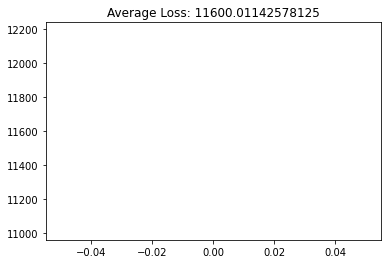

In [ ]:


import torch
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10, STL10
import tqdm
import os
from IPython import display as disp
import matplotlib.pyplot as plt
%matplotlib inline


score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   1
## learning rate
lr=1e-4
loss_arr = np.zeros(0)
exp_mov_avg = True


# dataset = CIFAR10('.', train=True, transform=transforms.ToTensor(), download=True)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
train_iterator = iter(cycle(train_loader))

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)

# Initialise EMA - new!
ema = EMA(0.999)
for name, param in score_model.named_parameters():
    if param.requires_grad:
        ema.register(name, param.data)

epoch = 0
# for epoch in tqdm_epoch:
while epoch < n_epochs:
  avg_loss = 0.
  num_items = 0

  for i in range(10):
    x, _ = next(train_iterator)
    # for x, y in data_loader:
    # only use x (feature minibatch) not y (label minibatch), replace with _?
    x = x.to(device)    
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()

    # Update EMA - only have this bit if we're using EMA
    if exp_mov_avg:
        for name, param in score_model.named_parameters():
            if param.requires_grad:
                param.data = ema(name, param.data)

    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Update the checkpoint after each epoch of training.
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  try:
    os.remove(f'ckpt_{epoch}.pth')
  except:
    pass
  epoch += 1
  #plotting
  try:
    disp.clear_output(wait=True)
  except:
    pass
  loss_arr = np.append(loss_arr, avg_loss / num_items)
  plt.plot(list(range(epoch)), loss_arr)
  plt.title(f'Average Loss: {avg_loss / num_items}')
  plt.show()
  
  torch.save(score_model.state_dict(), f'ckpt_{epoch}.pth')

In [ ]:


## The number of sampling steps for EM sampler
num_steps =  2
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=32, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3):
  """
  Generate samples from score-based models with the Euler-Maruyama solver.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 3, 32, 32, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

Millstein sampler takes the first two terms of the Taylor-Ito series for $X$. This assumes that the dirft and diffusion coefficients both satisfy the Lipschitz conditions. Additionally, the drift and diffusion coefficients should be twice differentiable.

In [ ]:
## The number of sampling steps for Milltein sampler
num_steps =  5000
def Millstein_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=32, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3):
  """
  Generate samples from score-based models with the Euler-Maruyama solver.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 3, 32, 32, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      g_ = derivative_diffusion_coeff(batch_time_step, sigma=25)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
      # add 2nd term
      x = x + 0.5*g[:, None, None, None]*g_[:, None, None, None]*(step_size*torch.randn_like(x)**2 - step_size)      
  # Do not include any noise in the last sampling step.
  return mean_x

In [ ]:

signal_to_noise_ratio =  0.16
num_steps =  50
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=32, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cuda',
               eps=1e-3):
  """
  Generate samples from score-based models with Predictor-Corrector method.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 3, 32, 32, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean

In [ ]:


from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=32, 
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cuda', 
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation 
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 3, 32, 32, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z
    
  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):        
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t    
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
  
  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x


run this code cell only ifyou are uplaoding a model you trained earlier as a `ckpt.pth` file

In [ ]:
import tqdm
device = 'cuda'
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


  0%|          | 0/20000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


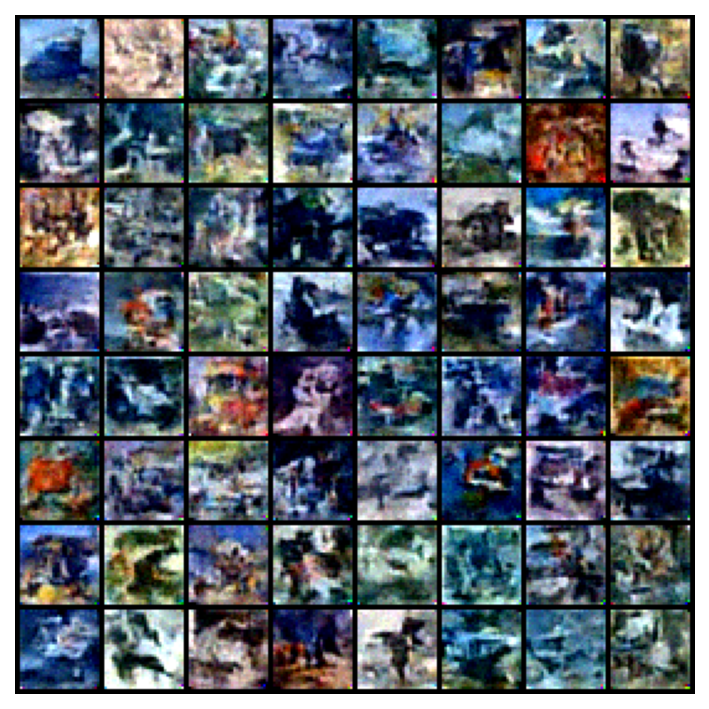

In [ ]:


from torchvision.utils import make_grid

## Load the pre-trained checkpoint 
ckpt = torch.load(f'ckpt_500.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size =  64
sampler = Millstein_sampler

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.rcParams['figure.dpi'] = 150
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


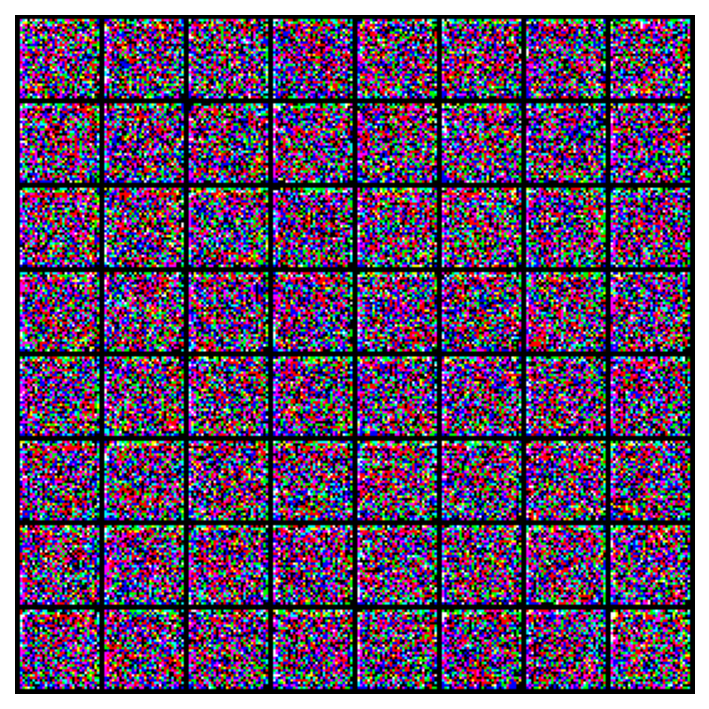

In [ ]:
# generating image from latent space by varying the amount of steps taken by the sampler (interpolation)
from torchvision.utils import make_grid

## Load the pre-trained checkpoint 
ckpt = torch.load(f'ckpt_500.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size =  64
sampler = pc_sampler

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.rcParams['figure.dpi'] = 150
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()